In [1]:
import pandas as pd
import numpy as np
!pip install pandas-ta
import pandas_ta as ta
from tensorflow.keras.layers import LSTM,Dense,Dropout,BatchNormalization,Bidirectional,Input,Conv1D,Flatten,Conv1D
from tensorflow.keras.activations import relu,sigmoid,tanh,linear
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
# from keras_tuner.tuners import BayesianOptimization
# from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping
import  matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split



In [2]:
df = pd.read_csv('sap500_daily.csv')

In [3]:
df = df.drop(columns='Volume',axis=1)

In [4]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close'], dtype='object')

In [5]:
# import pandas as pd
# df['Date'] = pd.to_datetime(df['Date'])
# df['week'] = df['time'].dt.day_name()
df.set_index('Date',inplace=True)
# print(df['week'].unique)

In [6]:
df['next_hour_Close'] = df['Close'].shift(-1)
df['ema5'] = ta.ema(df['Close'] , length=5)
df['ema10'] = ta.ema(df['Close'] , length=10)
# delta = df['Close'].diff()
df['upper_shadow'] = df['High'] - np.maximum(df['Open'], df['Close'])
df['Lower_shadow'] = np.minimum(df['Open'], df['Close']) - df['Low']
df['body'] = abs(df['Close'] - df['Open'])
df['candle_range'] = df['High'] - df['Low']
df['atr'] = df['High'] - df['Low']
df['atr'] = df['atr'].rolling(14).mean()

# gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
# loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
# rs = gain / loss
# df['RSI'] = 100 - (100 / (1 + rs))
# df['ema20'] = ta.ema(df['Close'] , length=20)
# df['ema50'] = ta.ema(df['Close'] , length=50)
# df['ema200'] = ta.ema(df['Close'] , length=200)
df['rsi'] = ta.rsi(df['Close'] , length=14)
macd = ta.macd(df['Close'], fast=12, sLow=26, signal=9)
df = pd.concat([df,macd],axis=1)
df['pivot'] = (df['High'] + df['Low'] + df['Close']) / 3
df['support_1'] = (2 * df['pivot']) - df['High']
df['support_2'] = df['pivot'] - (df['High'] - df['Low'])
df['resistance_1'] = (2 * df['pivot']) - df['Low']
df['resistance_2'] = df['pivot'] + (df['High'] - df['Low'])
bollinger = ta.bbands(df['Close'],length=20,std=2)
df = pd.concat([df,bollinger],axis=1)
stochastic = ta.stoch(df['High'], df['Low'], df['Close'], k=14, d=3, smooth_k=3)
df = pd.concat([df, stochastic], axis=1)
adx = ta.adx(df['High'], df['Low'], df['Close'], length=14)
df = pd.concat([df, adx], axis=1)
def fibonacci_retracement(df):
    High = df['High'].max()
    Low = df['Low'].min()

    diff = High - Low

    df['fibonaccilevel2'] = High - 0.382 * diff
    df['fibonaccilevel3'] = High - 0.5 * diff
    df['fibonaccilevel4'] = High - 0.618 * diff
    df['fibonaccilevel5'] = High - 0.764 * diff

    return df

# fibonacci_retracement(df)

def stochastic_oscillator(df, period=14, ma_period=3):
    df['L14'] = df['Low'].rolling(window=period).min()
    df['H14'] = df['High'].rolling(window=period).max()
    df['%K'] = (df['Close'] - df['L14']) * 100 / (df['H14'] - df['L14'])
    df['%D'] = df['%K'].rolling(window=ma_period).mean()
    return df
stochastic_oscillator(df)

# Additional pivot-based levels
df['support_3'] = df['Low'] - 2 * (df['High'] - df['pivot'])
df['resistance_3'] = df['High'] + 2 * (df['pivot'] - df['Low'])
# Fibonacci levels (common ratios)
fib_range = df['High'] - df['Low']
df['fib_236'] = df['High'] - fib_range * 0.236
df['fib_382'] = df['Close'] + fib_range * 0.382  # Common retracement
df['fib_618'] = df['Close'] - fib_range * 0.618  # Golden ratio
# Woodie's variation (uses 2*Close in calculation)
df['woodie_pivot'] = (df['High'] + df['Low'] + 2 * df['Close']) / 4
df['woodie_s1'] = 2 * df['woodie_pivot'] - df['High']
df['woodie_r1'] = 2 * df['woodie_pivot'] - df['Low']
# Camarilla system (uses different multipliers)
df['camarilla_s1'] = df['Close'] - (df['High'] - df['Low']) * 1.1 / 4
df['camarilla_r1'] = df['Close'] + (df['High'] - df['Low']) * 1.1 / 4
# Midpoints between key levels
df['mid_support'] = (df['support_1'] + df['support_2']) / 2
df['mid_resistance'] = (df['resistance_1'] + df['resistance_2']) / 2
# Alternative pivot calculation (includes Open price)
df['alt_pivot'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
# Moving average of pivot points
df['pivot_ma7'] = df['pivot'].rolling(window=7).mean()
df['pivot_ma21'] = df['pivot'].rolling(window=21).mean()
# Price range calculations
df['daily_range'] = df['High'] - df['Low']
df['range_pct'] = (df['daily_range'] / df['Close']) * 100

df['HA_Close'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4
df['HA_Open'] = (df['Open'].shift(1) + df['Close'].shift(1)) / 2
df['HA_High'] = df[['High', 'HA_Open', 'HA_Close']].max(axis=1)
df['HA_Low'] = df[['Low', 'HA_Open', 'HA_Close']].min(axis=1)
df['HA_Open'].iloc[0] = (df['Open'].iloc[0] + df['Close'].iloc[0]) / 2


C:\Users\Mahdimtd\AppData\Local\Temp\ipykernel_17148\2074699242.py:87: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['HA_Open'].iloc[0] = (df['Open'].iloc[0] + df['Close'].iloc[0]) / 2


In [7]:
df.isnull().sum()


Open                0
High                0
Low                 0
Close               0
next_hour_Close     1
ema5                4
ema10               9
upper_shadow        0
Lower_shadow        0
body                0
candle_range        0
atr                13
rsi                14
MACD_12_26_9       25
MACDh_12_26_9      33
MACDs_12_26_9      33
pivot               0
support_1           0
support_2           0
resistance_1        0
resistance_2        0
BBL_20_2.0         19
BBM_20_2.0         19
BBU_20_2.0         19
BBB_20_2.0         19
BBP_20_2.0         19
STOCHk_14_3_3      15
STOCHd_14_3_3      17
ADX_14             27
DMP_14             14
DMN_14             14
L14                13
H14                13
%K                 13
%D                 15
support_3           0
resistance_3        0
fib_236             0
fib_382             0
fib_618             0
woodie_pivot        0
woodie_s1           0
woodie_r1           0
camarilla_s1        0
camarilla_r1        0
mid_suppor

In [8]:
df.dropna(inplace=True)

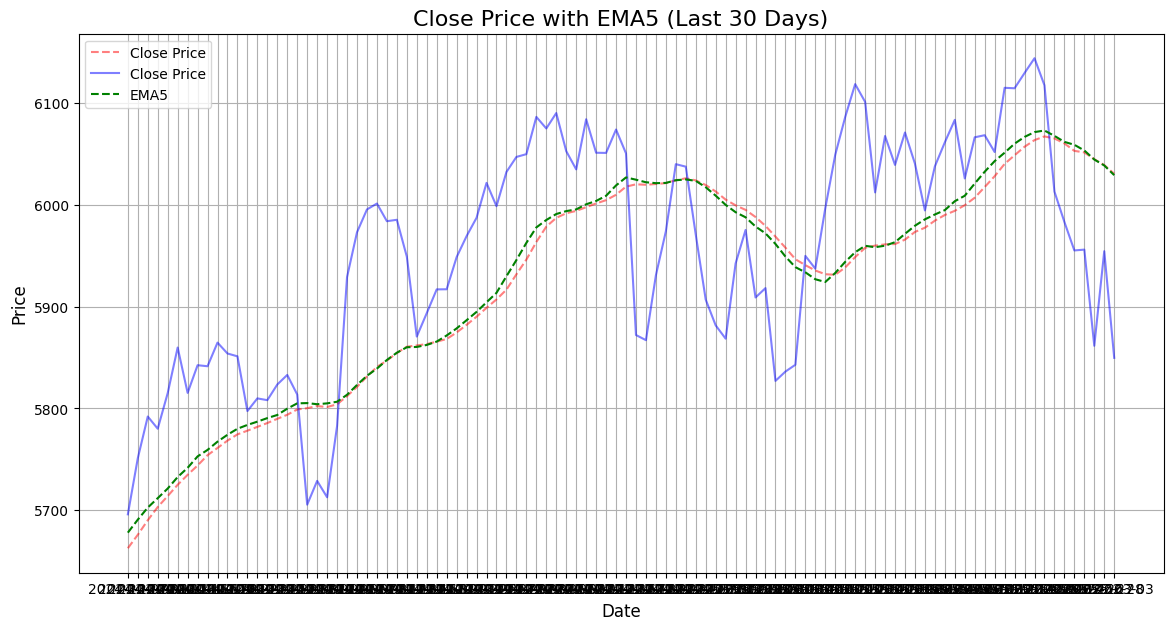

In [14]:
import matplotlib.pyplot as plt

# Select a subset of the data (e.g., last 30 days)
df_subset = df[-100:]  # آخرین 30 روز داده

# Plot the closing prices and EMA5
plt.figure(figsize=(14, 7))
plt.plot(df_subset.index, df_subset['pivot_ma21'], label='Close Price', color='red', alpha=0.5,linestyle='--')
plt.plot(df_subset.index, df_subset['Close'], label='Close Price', color='blue', alpha=0.5)
plt.plot(df_subset.index, df_subset['BBM_20_2.0'], label='EMA5', color='green', linestyle='--')

# Add labels and title
plt.title('Close Price with EMA5 (Last 30 Days)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [9]:
count_indices = df.index.size

print(count_indices)


24374


In [10]:
features = [
#  'Open',
#  'High',
#  'Low',
#  'Close',
#  'Volume',
#  'ema5',
#  'ema10',
#  'upper_shadow',
#  'Lower_shadow',
#  'body',
#  'candle_range',
#  'atr',
#  'rsi',
#  'MACD_12_26_9',
#  'MACDh_12_26_9',
#  'MACDs_12_26_9',
#  'pivot',
#  'support_1',
#  'support_2',
#  'resistance_1',
#  'resistance_2',
#  'BBL_20_2.0',
  'BBM_20_2.0',
  'BBU_20_2.0',
#  'BBB_20_2.0',
#  'BBP_20_2.0',
#  'STOCHk_14_3_3',
#  'STOCHd_14_3_3',
#  'ADX_14',
#  'DMP_14',
#  'DMN_14',
#  'L14',
#  'H14',
#  '%K',
#  '%D',
#  'support_3',
  'resistance_3',
#  'fib_236',
#  'fib_382',
#  'fib_618',
#  'woodie_pivot',
#  'woodie_s1',
#  'woodie_r1',
  'camarilla_s1',
#  'camarilla_r1',
#  'mid_support',
#  'mid_resistance',
#  'alt_pivot',
#  'pivot_ma7',
  'pivot_ma21',
#  'daily_range',
#  'range_pct',
#  'HA_Close',
#  'HA_Open',
#  'HA_High',
#  'HA_Low'
]
target = ['next_hour_Close']

# close              0.999833
# camarilla_s1       0.999827
# camarilla_r1       0.999825
# woodie_pivot       0.999824
# fib_382            0.999819
# pivot              0.999818
# woodie_s1          0.999813
# support_1          0.999810
# woodie_r1          0.999809
# resistance_1       0.999804
# alt_pivot          0.999803
# fib_618            0.999802
# low                0.999782
# mid_support        0.999779
# high               0.999773
# mid_resistance     0.999770
# support_2          0.999737
# resistance_2       0.999722
# open               0.999720
# ema5               0.999698
# support_3          0.999639
# resistance_3       0.999621
# ema10              0.999494
# pivot_ma7          0.999487
# ema20              0.999074
# L14                0.998902
# BBM_20_2.0         0.998797
# H14                0.998785
# pivot_ma21         0.998697
# BBL_20_2.0         0.998270
# BBU_20_2.0         0.998088
# ema50              0.997838
# ema200             0.992243

In [11]:
X = df[features].values
y = df[target].values.reshape(-1, 1)

In [12]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()


X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [14]:
Sequence_len = 40

def creat_sequences(X,y,sequence_len):
  X_seq = []
  y_seq = []
  for i in range(len(X)-sequence_len):
    X_seq.append(X[i:i+sequence_len])
    y_seq.append(y[i+sequence_len])
  return np.array(X_seq),np.array(y_seq)

In [15]:
X_final,y_final = creat_sequences(X_scaled,y_scaled,Sequence_len)

In [16]:
print(X_final.shape)
print(y_final.shape)

(24334, 40, 5)
(24334, 1)


In [17]:
split_index = int(len(X_final)*0.90)
x_train = X_final[:split_index]
y_train = y_final[:split_index]
x_test = X_final[split_index:]
y_test = y_final[split_index:]

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(21900, 40, 5)
(21900, 1)
(2434, 40, 5)
(2434, 1)


In [19]:

model = Sequential()
model.add(Input(shape=(Sequence_len, x_train.shape[2])))
model.add(LSTM(384,kernel_regularizer=l2(5.549602976953121e-05)))
model.add(Dense(48,kernel_regularizer=l2(1.0993810979042252e-06)))
model.add(Dense(1, activation='linear'))


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 384)                 │         599,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 48)                  │          18,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 617,569 (2.36 MB)

 Trainable params: 617,569 (2.36 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
Es = EarlyStopping(monitor='val_mae',patience=10)
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
# history = model.fit(x_train, y_train, epochs=200, validation_data=(x_train, y_train),callbacks=Es)
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_train, y_train),callbacks=Es)

Epoch 1/200
685/685 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.0049 - mae: 0.0235 - val_loss: 4.2396e-04 - val_mae: 0.0092
Epoch 2/200
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 3.7983e-04 - mae: 0.0074 - val_loss: 3.0835e-04 - val_mae: 0.0054
Epoch 3/200
685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 3.3819e-04 - mae: 0.0075 - val_loss: 2.7877e-04 - val_mae: 0.0043
Epoch 4/200
685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 2.9661e-04 - mae: 0.0069 - val_loss: 4.0632e-04 - val_mae: 0.0128
Epoch 5/200
685/685 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 2.7664e-04 - mae: 0.0073 - val_loss: 4.4173e-04 - val_mae: 0.0165
Epoch 6/200
685/685 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 2.6658e-04 - mae: 0.0078 - val_loss: 3.1246e-04 - val_mae: 0.0117
Epoch 7/200
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 2.5228e-04 - mae: 0.0079 - val_loss: 2.0968e-04 - val_mae: 0.0079
Epoch 8/200
685/685 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 2.1906e-04 - mae: 0.0072 - val_loss: 2.151

In [21]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - mae: 0.0240
Test Loss: 0.002502482384443283, Test MAE: 0.03459644690155983


In [22]:
y_pred = model.predict(x_test)

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [23]:
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)

In [24]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

MAE: 38.29314072169333
MSE: 3014.709179594568
RMSE: 54.90636738662072
R-squared: 0.9975647549943579


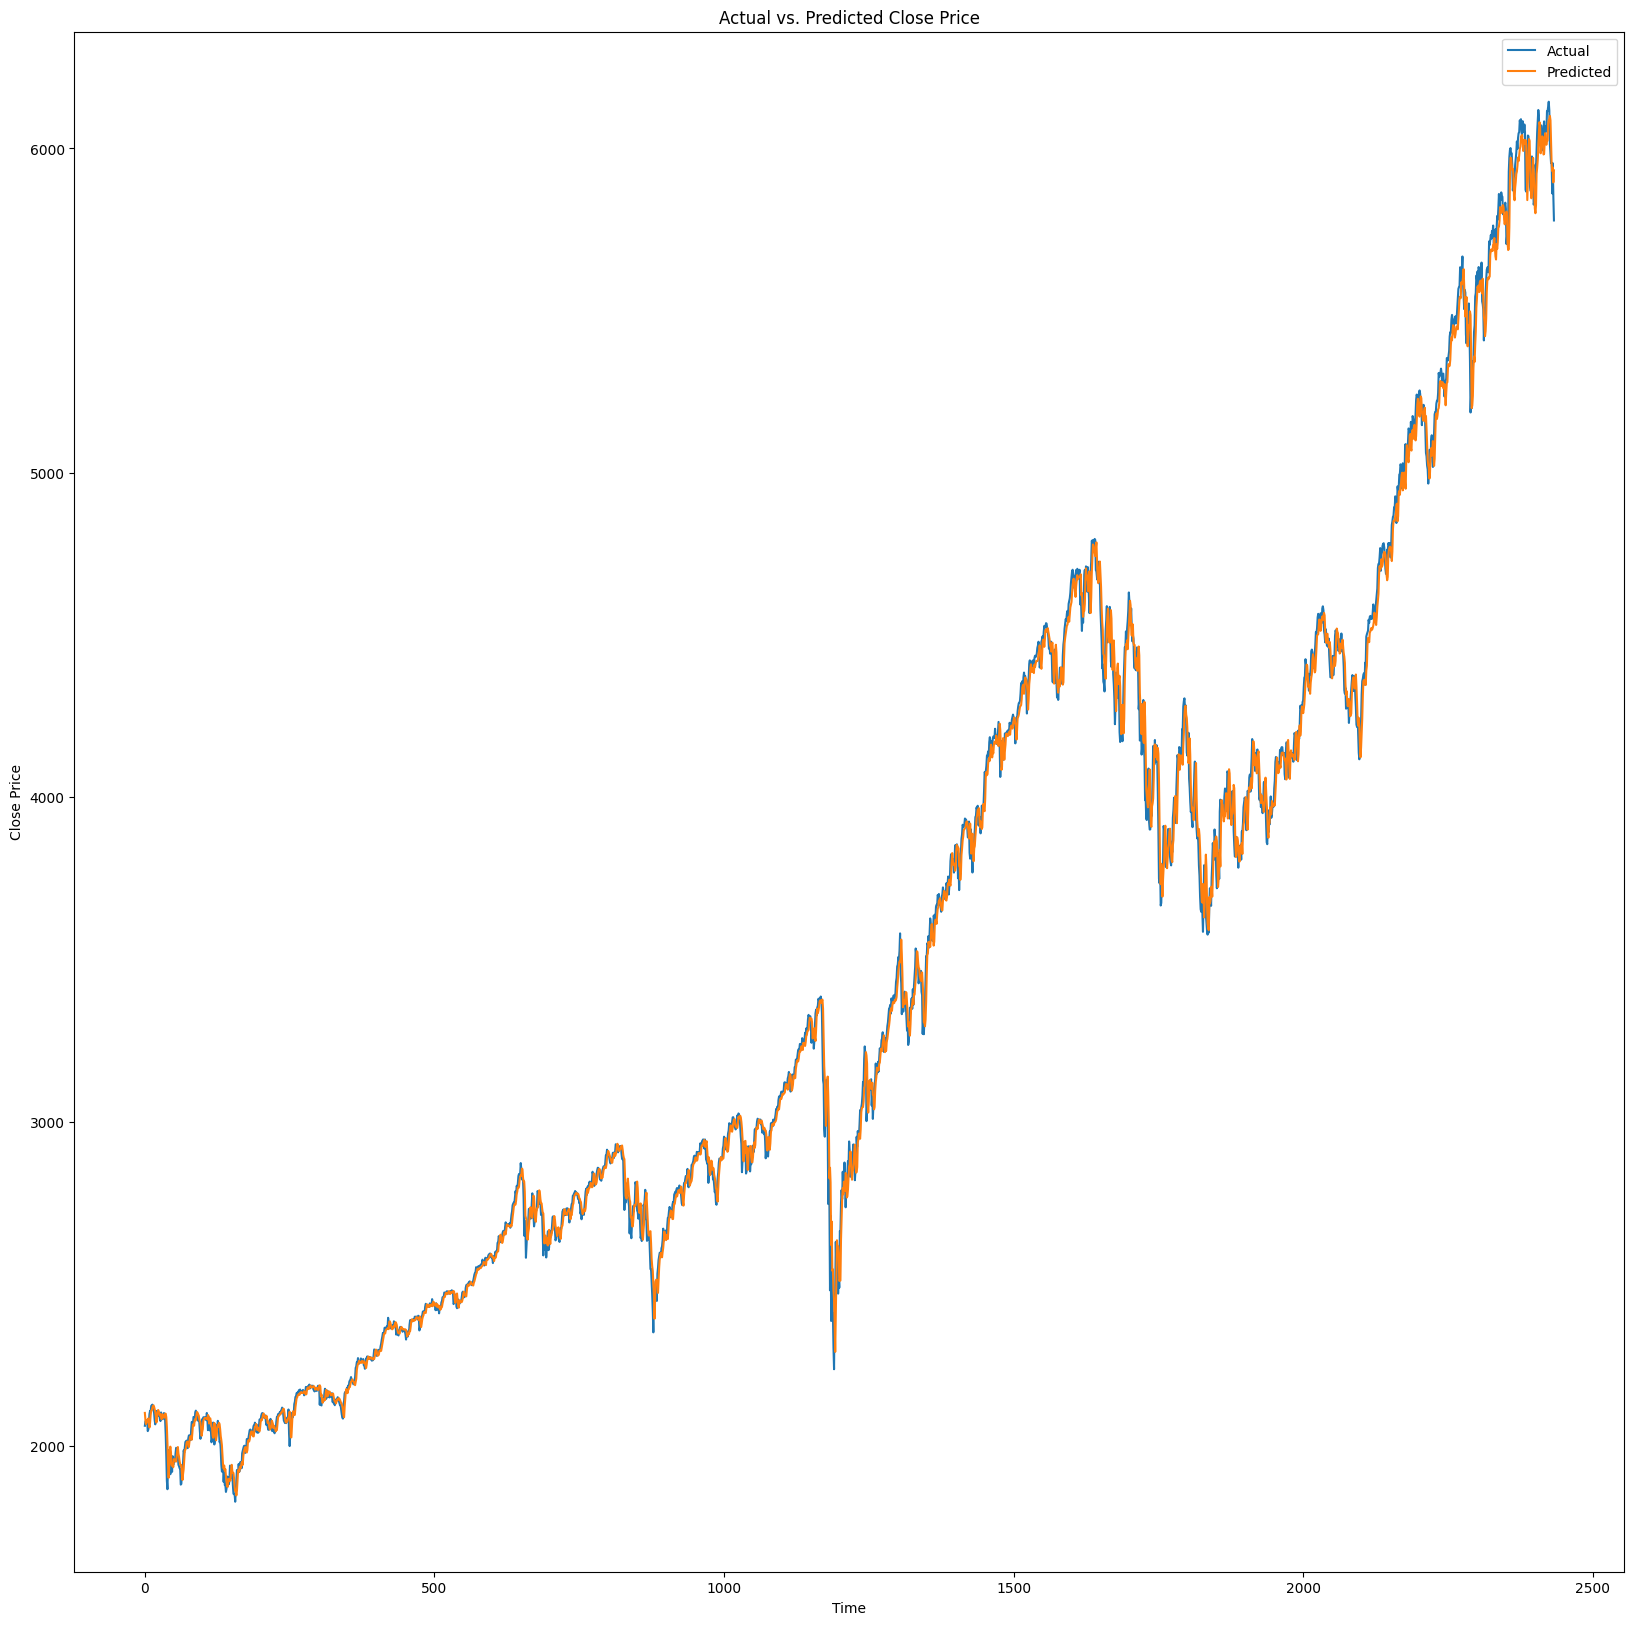

In [29]:
plt.figure(figsize=(20, 20))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [26]:
df_results = pd.DataFrame({
    'Actual': y_test.flatten(),
    'Predicted': y_pred.flatten()
}, index=df.index[-len(y_test):])

df_results.to_csv('daily result.csv')

print("Results saved to 'daily result.csv'")
from google.colab import files

files.download('daily result.csv')

Results saved to 'daily result.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
def evaluate_predictions(y_test, y_pred):
    # محاسبه معیارهای دقت مدل
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    # بررسی جهت حرکت قیمت‌ها
    correct_direction = np.sum(np.sign(y_pred[1:] - y_pred[:-1]) == np.sign(y_test[1:] - y_test[:-1]))
    accuracy = correct_direction / (len(y_test) - 1) * 100

    print(f"Trend Direction Accuracy: {accuracy:.2f}%")

In [28]:
evaluate_predictions(y_test, y_pred)


Mean Absolute Error (MAE): 38.2931
Root Mean Squared Error (RMSE): 54.9064
Mean Absolute Percentage Error (MAPE): 1.09%
Trend Direction Accuracy: 50.02%
